## Machine Vision Final project: DETECT CONSTRUCTION WORKER

### Members: 
    1.Dinh Duc Duy - 22134001 
    2.Huynh Thanh Phong - 22134009 
    3.Le Quoc Thinh - 22134013 

![Flowchart](Notebook-4.jpg)

In [1]:
# Ignore warning 
import warnings
warnings.filterwarnings('ignore') 

# Common libraies 
%matplotlib inline 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import datetime 

import os # Working with path, directories 
import yaml # Working with yaml file ( write )


from PIL import Image # Load image 
import cv2 as cv
import random 

from ultralytics import YOLO # Train YOLO model 
import torch # Check GPU status, dependencies 

### 0. Dataset 

#### a. Preprocessing 

In [3]:
# GRAYSCALE image randomly 
folder_dir = 'RawData/'

# Random some image for grayscale ( About 150 )
np.random.seed(42) # Ensure the same image are random 
num_image = 150  
images = os.listdir(folder_dir)
images_path = np.random.choice(images, num_image)

# Grayscale and save each image 
for image_path in images_path:
    img = cv.imread(os.path.join(folder_dir, image_path))
    if img is not None:
        # Grayscale 
        grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Replace origin image with grayscale image 
        output_path = os.path.join(folder_dir, image_path) 
        cv.imwrite(output_path, grayscale)
    else: 
        print(f'Could not grayscale image at path {image_path}')

print('IMG grayscale completed')

IMG grayscale completed


In [4]:
# Binarization image randomly 
folder_dir = 'RawData/'

# Random some image for binarization ( About 150 )
np.random.seed(21)
num_image = 150  
images = os.listdir(folder_dir)
images_path = np.random.choice(images, num_image)

# Grayscale and save each image 
for image_path in images_path:
    img = cv.imread(os.path.join(folder_dir, image_path))
    if img is not None:
        # Binarization image 
        grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        _, b_image = cv.threshold(grayscale, 120, 255, cv.THRESH_BINARY)

        # Replace origin image with binarization image 
        output_path = os.path.join(folder_dir, image_path) 
        cv.imwrite(output_path, grayscale)
    else: 
        print(f'Could not grayscale image at path {image_path}')
cv.waitKey(0)
cv.destroyAllWindows()
print('IMG binarization completed')

IMG binarization completed


In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.05):
    # Copy the image to avoid modifying the original
    noisy_image = np.copy(image)
    
    # Calculate the number of salt and pepper pixels to add
    total_pixels = image.size
    num_salt = int(salt_prob * total_pixels)
    num_pepper = int(pepper_prob * total_pixels)
    
    # Add salt noise (white pixels)
    for _ in range(num_salt):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 255
    
    # Add pepper noise (black pixels)
    for _ in range(num_pepper):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 0
    
    return noisy_image

# Raw data directionry 
folder_dir = 'RawData/'

# Random some image to add noise ( About 80 )
np.random.seed(20)
images = os.listdir(folder_dir)
num_image = 150  

images_path = np.random.choice(images, num_image)
prob = [0.01, 0.02, 0.03, 0.04, 0.05]
for image_path in images_path: 
    # Load image 
    img = cv.imread(os.path.join(folder_dir, image_path))

    # Add noise 
    salt_prob = np.random.choice(prob)
    pepper_prob = np.random.choice(prob)
    noisy_image = add_salt_and_pepper_noise(img,salt_prob, pepper_prob)

    # Replace origin imaeg with noisy image
    output_path = os.path.join(folder_dir, image_path)
    cv.imwrite(output_path, noisy_image)

print('IMG add noise completed')

IMG add noise completed


In [6]:
def Rotate(img, angle):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our img by 45 degrees around the center of the img
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv.warpAffine(img, M, (w, h)) 
    return rotated

def Random_Rotate(img):
    angle = random.choice([0, 90, 180, 270])
    return Rotate(img, angle)

# Raw data directionry 
folder_dir = 'RawData/'

# Random some image to add noise ( About 150 )
np.random.seed(10)
images = os.listdir(folder_dir)
num_image = 150 
images_path = np.random.choice(images, num_image)
for image_path in images_path: 
    img = cv.imread(os.path.join(folder_dir, image_path))  
    rotated_image = Random_Rotate(img)
    cv.imwrite(output_path, rotated_image)

print('IMG rotate completed')

IMG rotate completed


#### b. Download data 

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key='oGXN61neFO0hOoEtXIJZ')
project = rf.workspace("phong-huynh").project("annotate_ppe")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.22, to fix: `pip install ultralytics==8.0.196`


#### Dataset 

In [2]:
# Directories 
DATASET_DIR = 'Annotate_PPE-4/'
train_folder = os.path.join(DATASET_DIR, 'train/images')
val_folder = os.path.join(DATASET_DIR, 'valid/images')
test_folder = os.path.join(DATASET_DIR, 'test/images')

# Information of dataset 
CLASSES_IDX = [0,1,2,3,4,5,6]
CLASSES_NAME = ['boots', 'dust mask',  'glass',  'gloves', 'helmet', 'person', 'safety vest']
NUM_CLASSES_TO_TRAIN = len(CLASSES_NAME)

In [3]:
def plot_random_images_from_folder(folder_path, num_images=20):
    '''
    This function use to plot (multiple) image from folder for visualize 
    Parameter: 
        - folder_path (str): the path of image(s) folder 
        - num_images (int, default = 20 ): the number of imaegs want to plot ( want to display )
    Return: 
        - void 
    '''
    
    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = np.random.choice(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

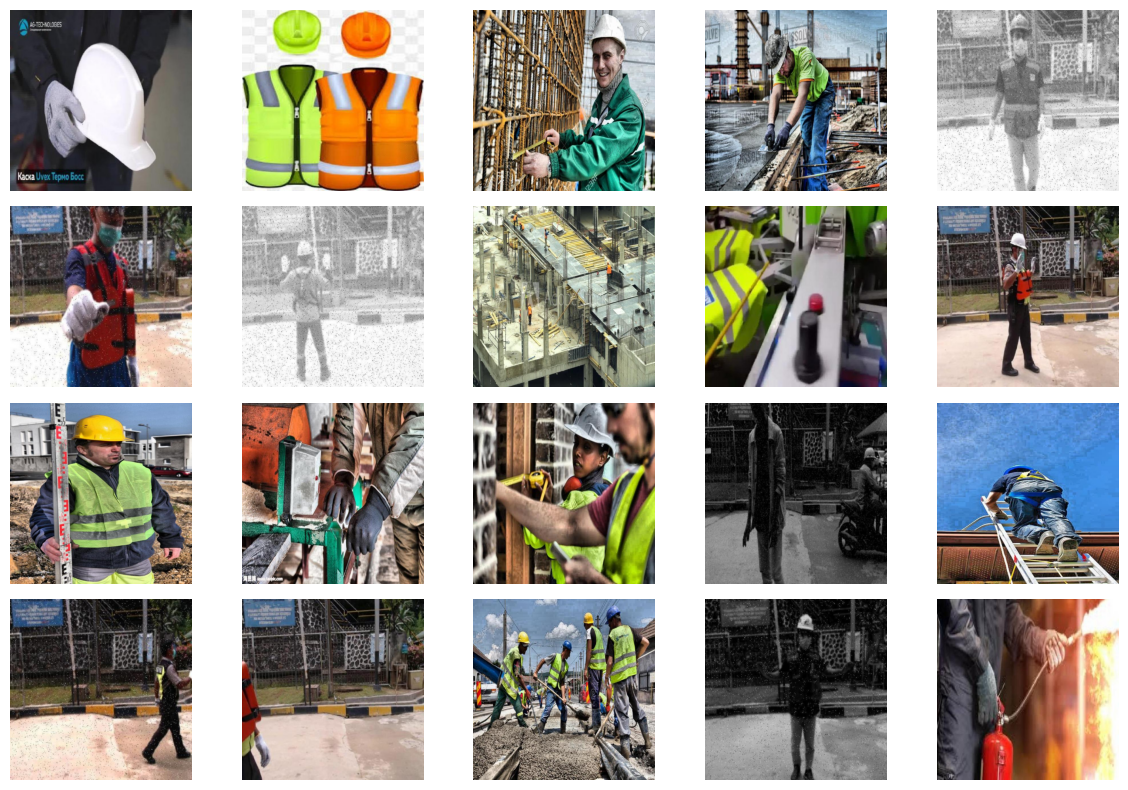

In [4]:
plot_random_images_from_folder(train_folder, num_images=20)  

#### Image properties 

In [5]:
def get_image_properties(image_path):
    '''
    This function use to show properties of image 
    Parameter: 
        - image_path (str): the path of image want to show properties 
    Return:
        - properties (dict): information about: {width, heigh, channel, dtype} of image 
    
    '''
    img = cv.imread(image_path)
    if img is None: 
        raise ValueError('Could not read image file' ) 

    # Get properties 
    properties = {
        'width' :img.shape[1], 
        'height' : img.shape[0],
        'channels': img.shape[2] if len(img.shape) == 3 else 1, 
        'dtype': img.dtype
    
    }
    return properties 

In [6]:
# Random image in train folder 
images = os.listdir(train_folder)
image = np.random.choice(images)
image_path = os.path.join(train_folder, image)

# Show properties of random image 
img_properties = get_image_properties(image_path) 
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

#### Dataset statistics 

In [9]:
class_idx = {str(i): CLASSES_NAME[i] for i in range(NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CLASSES_NAME[i]: 0 for i in range(NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_status_df = pd.DataFrame(class_info)
dataset_status_df

,Mode,boots,dust mask,glass,gloves,helmet,person,safety vest,Data_Volume
0,train,1620,1214,896,1868,2518,3085,2739,3688
1,valid,195,144,111,219,281,358,321,421
2,test,91,72,60,108,148,172,148,214


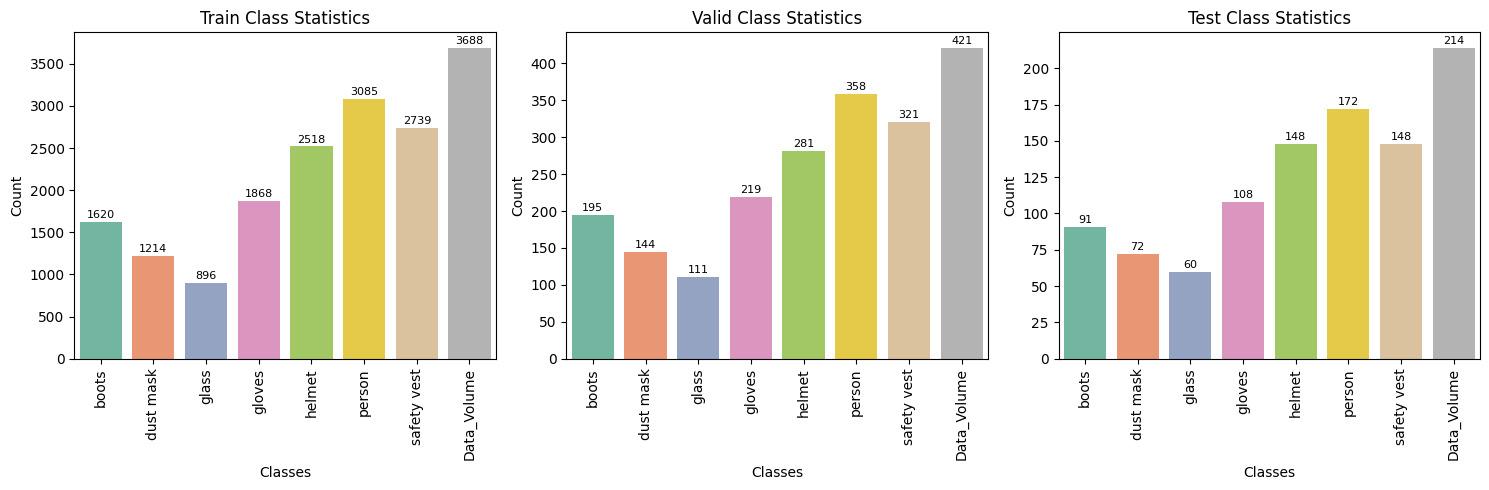

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_status_df[dataset_status_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### 2.Base Model Inference 

#### Check GPU 

In [7]:
# Check cuda -  gpu 
!nvidia-smi 

Thu Jun 27 10:34:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P3             30W /   55W |      15MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
# Check torch (gpu version)
torch.cuda.is_available()

True

#### 2.1 PPE Model 

##### Model parameters explained: 
1. **SEED = 42**

- This sets a seed for random number generation, ensuring reproducibility of your model training. It ensures that the random elements of the algorithms (like initialization of weights, shuffling of data) are consistent across runs.

2. **EPOCHS = 3 if DEBUG else epochs**

- This controls how many times the entire dataset is passed through the neural network. If in debug mode, it's set to 3 for quick testing; otherwise, it uses a variable `epochs` for more extensive training.

3. **BATCHSIZE = batchsize**

- This is the number of training samples to work through before the model’s internal parameters are updated. It's a balance between efficiency and memory usage.

4. **OPTIMIZER = 'auto'**

- The optimizer is the algorithm used to update weights in the network. Setting this to 'auto' likely means that a default optimizer is chosen based on other model settings or that the best choice is determined automatically.

5. **LR = 1e-3**

- This is the learning rate, a crucial hyperparameter in training neural networks. It defines the step size during the minimization of the loss function.

6. **LR_FACTOR = 0.01**

- This is typically used with a learning rate scheduler, which adjusts the learning rate based on certain criteria or after a certain number of epochs. A factor of 0.01 reduces the learning rate by 99% when the adjustment is triggered.

7. **WEIGHT_DECAY = 5e-4**

- This is a regularization parameter (often used in L2 regularization), adding a penalty on the size of weights. It helps prevent the model from overfitting by penalizing large weights.

8. **DROPOUT = 0.0**

- Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time, which helps to mimic a sparse activation from a randomly selected subset of neurons.

9. **PATIENCE = 20**

- This parameter is used in conjunction with early stopping, a form of regularization used to avoid overfitting. If the model's performance doesn't improve for 20 epochs, training is halted.

10. **PROFILE = False**

- This is likely a debugging or performance monitoring tool that, when set to True, would provide detailed logs or profiles of model training, such as time and memory usage for different parts of the training process.

11. **LABEL_SMOOTHING = 0.0**

- Label smoothing is a technique that helps to make the model less confident during training, by smoothing the labels. This means that instead of having a hard target of 1 for the true class and 0 for all others, the targets are adjusted to be slightly less extreme, which can help improve the generalization of the model.

12. **val = True**

- Validation should be performed

13. **amp = True**

- Enables the use of automatic mixed precision training (amp). Mixed precision training uses both 32-bit and 16-bit floating-point types during training which can result in faster computation and reduced memory usage without significantly impacting the accuracy of the model

14. **exist_ok = True**

- This parameter is typically used in file operations, indicating that it's okay if the file or directory already exists. 

15. **resume = False**

- Enable if user want to resume training from the previous checkpoint.

16. **device = [0]**

- Use the first GPU device to train the model

17. **verbose = False**

- This controls the verbosity of the output during training. When set to False, the training process will output less information to the console or log files.

In [3]:
class modelPPE: 
    def __init__(self, base_model,classes ,data_path,DEBUG = False, batchsize = 8, epochs= 20):
        """
        Init function
        Parameters: 
         - base_model (str): name of yolo model use to train 
         - data_path (str): path of dataset
         - batchsize (int): batch size use to train YOLO model (default = 8 )
         - epochs (int): the numbers of epochs use to train (default= 20)
         - DEBUG (boolean): debug mode, use to debug 

        """
        # Model information 

        self.CLASSES = classes 
        
        self.NUM_CLASSES = len(self.CLASSES)
        
        self.SEED = 42 
        self.EPOCHS = 3 if DEBUG else epochs # Number of epochs used to train 
        self.BATCHSIZE = batchsize # Number of batch sample used to train 
        self.OPTIMIZER = 'auto' # The optimizer used to update the weights and aim to minimize lr while training
        self.LR = 1e-3 # The learning rate used to define the step size to minimize the loss function
        self.LR_FACTOR = 0.01 # The lr factor used to change the lr based on criteria during training 
        self.WEIGHT_DECAY = 5e-4 # A regularization parameter to adjust the size of weights
        self.DROPOUT = 0.0 # The Dropout parameter used to prevent overfitting.
        self.PATIENCE = 20 # Early stopping patience.
        self.PROFILE = False # Show the profiles of model for debugging 
        self.LABEL_SMOOTHING = 0.0 # Make the model less confident, improve generalization of model  


        self.DATASET_DIR = data_path 
        self.OUT_DIR = './'

        self.BASE_MODEL = base_model # yolov8m 
        self.model = YOLO(self.BASE_MODEL)
        self.NAME  = f'{self.BASE_MODEL}_train_{self.EPOCHS}_epochs' # Use to save 

        
    def create_yaml_file(self,file_name):
        """
        This function use to create a yaml file for training YOLO model 
        Parameter: 
            - file_name (str.yaml): name of yaml file 
        Return: 
            - (str): directory of yaml file  
        
        """
        
        # Create configuration  
        config = {           
            'train': os.path.join(self.DATASET_DIR, 'train'), 
            'val': os.path.join(self.DATASET_DIR, 'valid'), 
            'test': os.path.join(self.DATASET_DIR, 'test'), 
            'nc': self.NUM_CLASSES, 
            'names': self.CLASSES  
        }

        # Write a yaml file 
        with open(os.path.join(self.OUT_DIR, file_name), 'w+') as file: 
            yaml.dump(config, file, default_flow_style= False)

        return os.path.join(self.OUT_DIR, file_name)
        
        
    def train(self,data_yaml,image_width, image_height): 
        """
        This function use to train a YOLO model 
        Parameter:
            - data_yaml (file.yaml): Path to the YAML file with dataset configuration.
            - image_width (int): width of image 
            - image_height (int): height of image 
        Return:
            None 
        
        """
        self.model.train(
            data= data_yaml,
            task = 'detect', 
            
            imgsz = (image_height, image_width), 
            
            epochs = self.EPOCHS, 
            batch = self.BATCHSIZE, 
            optimizer = self.OPTIMIZER, 
            lr0= self.LR, 
            lrf= self.LR_FACTOR,
            weight_decay = self.WEIGHT_DECAY, 
            patience= self.PATIENCE, 
            profile= self.PROFILE, 
            label_smoothing= self.LABEL_SMOOTHING, 

            name = self.NAME, 
            seed = self.SEED,

            val= True, # Enable validation mode
            amp= True, # Enable the automatic mixed precision mode
            exist_ok= True, # Allow to replace the existing file
            resume= False, # Disable to resume the training process from the previous checkpoint
            device = [0], # GPU device 
            verbose= False # Lessen the information output
        )
        
        
    def load_best_model(self):
        """
        This function use to load the best model (YOLO model)
        """
        best_model_path = os.path.join('runs', 'detect', self.NAME, 'weights', 'best.pt')
        if not os.path.exists(best_model_path):
            raise FileNotFoundError(f'Can not found this model')
        return YOLO(best_model_path)


    def evaluate(self, model,data_yaml):
        """
        Evaluate the model using the YOLO library's val method.
        
        Parameters:
            - model (YOLO model): model want to make evaluate 
            - data_yaml (str): path to the data.yaml file
        
        Returns:
            - None 
        """
        # Perform validation 
        val_folder = 'runs/detect/val/' 
        
        # Perform validation
        metrics = model.val(data=data_yaml, exist_ok=True)
    
        # Extract information
        normalized_conf_matrix = os.path.join(val_folder, 'confusion_matrix_normalized.png')
        conf_matrix = os.path.join(val_folder, 'confusion_matrix.png')
        precision = os.path.join(val_folder, 'P_curve.png')
        recall = os.path.join(val_folder, 'R_curve.png')
        images = [conf_matrix, normalized_conf_matrix, precision, recall]
    
        # Check if all images exist
        for image in images:
            if not os.path.exists(image):
                print(f"Image not found: {image}")
                return
    
        # Plot
        fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(40, 40))
        for i, image in enumerate(images):
            img = plt.imread(image)
            axs[i].imshow(img)
            axs[i].axis('off')
        plt.show()
        

    def predict_images(self, model, images_path): 
        """
        This function use to make prediction and plot result 
        Parameter: 
            - model (YOLO model): the model want to use to make predict 
            - images_path (str or np.array): path of image(s) want to predict 
        Returns:
            - detects ():  the results of YOLO model
        """
        # Set up for visualize ( plot )
        detects = []
        num_cols = 2 
        num_rows = int(len(images_path))
        fig, axs = plt.subplots(ncols= num_cols, nrows= num_rows, figsize= [15,8*len(images_path)]) 
        
        for i,image_path in enumerate(images_path): 
            # Load image 
            origin_image = cv.imread(image_path)
            display_image = cv.cvtColor(origin_image, cv.COLOR_BGR2RGB)
    
            # Raise if have error 
            if origin_image is None: 
                raise ValueError(f'Image at path {image_path} can not be loaded')
    
                
            # Show origin image 
            axs[0].imshow(display_image) if len(images_path) == 1 else axs[i,0].imshow(display_image)
            axs[0].axis('off') if len(images_path) == 1 else axs[i,0].axis('off')
    
            # Prediction 
            detect = model(origin_image)[0]
            detects.append(detect)
            for result in detect.boxes.data.tolist():
                x1, y1, x2, y2, score, class_id = result
                x1 = int(x1)
                y1 = int(y1)
                x2 = int(x2)
                y2 = int(y2)
                # Plot bounding box 
                if score > 0.6: 
                    cv.rectangle(display_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv.putText(display_image, detect.names[int(class_id)].upper(), (x1, y1-10), cv.FONT_HERSHEY_COMPLEX, 0.6, (0,255,0), 1) 
            axs[1].imshow(display_image) if len(images_path) ==1 else axs[i,1].imshow(display_image)
            axs[1].axis('off') if len(images_path) == 1 else axs[i,1].axis('off')
        return detects # Return result 
        plt.show()


    def predict_video(self, model, video_path): 
        '''
        This function uses YOLO model to make predictions in a video.
    
        Parameters: 
            - model (YOLO model): model used to make predictions
            - video_path (str): path to the video file
        Return: 
            - void 
        '''
        cap = cv.VideoCapture(video_path)
    
        # Get video information
        frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv.CAP_PROP_FPS))

        # Output path 
        output_path = 'output_video.avi'
        
        # Print out video information
        print('Frame width:', frame_width)
        print('Frame height:', frame_height)
        print('FPS:', fps)

        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*'XVID')
        out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
        
        while cap.isOpened():
            ret, frame = cap.read()
    
            # Check status
            if not ret:
                print(f'Video at path {video_path} cannot be loaded or has ended.')
                break 
    
            results = model(frame)[0]
            for result in results.boxes.data.tolist():
                x1, y1, x2, y2, score, class_id = result
                x1 = int(x1)
                y1 = int(y1)
                x2 = int(x2)
                y2 = int(y2)
                if score > 0.4:
                    cv.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
                    cv.putText(frame, results.names[int(class_id)].upper(), (x1, y1-10), cv.FONT_HERSHEY_COMPLEX, 0.4, (0, 255, 0), 1)
    
            out.write(frame)
            # cv.imshow('Video', frame)
            # if cv.waitKey(1) & 0xFF == ord('q'):
            #     break 
    
        cap.release()
        out.release()
        cv.destroyAllWindows()
        print('Video processing complete. Output saved at', output_path)
        
        
    def summary(self):
        model_details = {
            "Model": self.BASE_MODEL,
            "Epochs": self.EPOCHS,
            "Batch size": self.BATCHSIZE,
            "Optimizer": self.OPTIMIZER,
            "Learning Rate Initial": self.LR,
            "Learning Rate Factor": self.LR_FACTOR,
            "Weight Decay": self.WEIGHT_DECAY,
            "Data path": self.DATASET_DIR,
            "Number of Classes": self.NUM_CLASSES,
            "Hardware": torch.cuda.get_device_name(), 
            'Cuda version': torch.version.cuda, 
            'Dependencies': torch.__version__ 
            
        }
        
        # Convert dictionary to list of dictionaries for each row
        summary_list = [{'Detail': key, 'Value': value} for key,value in model_details.items()]
        
        # Create DataFrame
        summary = pd.DataFrame(summary_list)
        return summary

        

In [4]:
base_model = 'yolov8m.pt'
data_path = DATASET_DIR
model = modelPPE(base_model= base_model, classes= CLASSES_NAME, data_path= DATASET_DIR, 
                 batchsize= 12, epochs=120,DEBUG= False      
                 )

#### 2.2 Summary model 

In [5]:
summary = model.summary()
summary

,Detail,Value
0,Model,yolov8m.pt
1,Epochs,120
2,Batch size,12
3,Optimizer,auto
4,Learning Rate Initial,0.001
5,Learning Rate Factor,0.01
6,Weight Decay,0.0005
7,Data path,Annotate_PPE-4/
8,Number of Classes,7
9,Hardware,NVIDIA GeForce RTX 3070 Laptop GPU


#### 2.3 Yaml file

In [16]:
# Create a yaml file 
model.create_yaml_file('data.yaml')

'./data.yaml'

#### 2.4 Train model

In [17]:
# Train model 
model.train('data.yaml', 640, 640 )

New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7878MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=120, time=None, patience=20, batch=12, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov8m.pt_train_120_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

train: Scanning /home/quocthinh/Desktop/JupyterCode/PPE_Detection_Part2/Annotate


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/quocthinh/Desktop/JupyterCode/PPE_Detection_Part2/Annotate_P


Plotting labels to runs/detect/yolov8m.pt_train_120_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8m.pt_train_120_epochs
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      5.79G       1.38      1.512      1.421         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        391       2417      0.751      0.623      0.691      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      5.71G      1.409      1.236      1.451         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.744      0.636      0.704      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      5.21G      1.407      1.205      1.442         86        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.743      0.693      0.748      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      5.21G      1.402      1.193      1.439         72        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.758      0.712      0.764      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      5.54G      1.364        1.1       1.41         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.794      0.747      0.797      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120       5.2G      1.332      1.049      1.393         69        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.812       0.75      0.805      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      5.64G      1.304      1.007      1.374         97        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.811      0.735      0.805      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120       5.2G      1.284     0.9609      1.359         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.824       0.77       0.82       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      5.22G      1.276     0.9392      1.346         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.818      0.764      0.817      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      5.71G      1.255      0.911      1.343         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.841      0.771      0.811      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      5.51G      1.249     0.9062      1.335         76        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.838      0.784      0.837        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      5.65G      1.232     0.8746      1.322         73        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.83      0.787       0.84      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      5.22G      1.218      0.861      1.317         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.814      0.778       0.84      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      5.12G      1.212     0.8378      1.312         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.822      0.806      0.848      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      5.53G      1.202     0.8239      1.299         97        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.849      0.804      0.857      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120       5.2G      1.192     0.8118       1.29        104        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.838      0.818      0.857      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      5.64G      1.184     0.8063      1.285         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.859      0.795      0.854      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      5.21G      1.182     0.7924      1.293         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.877      0.795      0.862      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      5.17G      1.178     0.7846      1.287         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.862      0.799      0.856      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      5.53G      1.171     0.7705      1.281         95        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.881       0.79      0.866      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      5.53G      1.156     0.7533       1.26         77        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.836      0.836      0.872      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      5.65G      1.158     0.7478      1.271         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.845       0.83      0.863      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120       5.2G       1.15     0.7462      1.266        107        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.844      0.825       0.87      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      5.24G      1.146      0.742      1.262         83        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.831      0.827      0.864      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      5.52G      1.143     0.7279      1.255         90        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.856      0.817      0.868       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      5.21G      1.127     0.7211      1.261         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.838      0.841      0.873      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      5.64G      1.129     0.7143      1.258         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.858      0.834       0.87      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      5.21G      1.124     0.7156       1.25         69        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.825      0.837      0.869      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      5.21G       1.12     0.6992      1.244         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.844      0.834      0.864      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      5.54G      1.109     0.6959      1.237         79        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.844      0.829      0.868      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      5.21G      1.116     0.6885      1.232         67        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.84       0.84      0.871      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      5.64G      1.097     0.6792      1.228         79        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.837      0.838      0.883      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120       5.2G      1.099     0.6761      1.232         98        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.835       0.85      0.885      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      5.51G      1.096     0.6837      1.231         96        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.83      0.848      0.873      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      5.36G       1.08     0.6597      1.218         77        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.841      0.852      0.877       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      5.51G      1.092     0.6664       1.23         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.839      0.835      0.866      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      5.64G      1.077      0.651      1.213        108        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.85      0.843      0.887      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120       5.2G      1.069      0.644       1.21         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.864      0.833      0.886      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      5.19G      1.072     0.6491      1.214         87        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.847       0.84      0.875       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      5.53G      1.064     0.6467      1.206        109        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.884      0.809      0.882       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120       5.2G      1.069     0.6416      1.208         81        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.871      0.835      0.881      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      5.64G      1.058     0.6378      1.206         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.847      0.858      0.886      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120       5.2G      1.049     0.6204      1.199         76        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.876      0.832      0.882      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120       5.2G      1.049     0.6208      1.196         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.864      0.843      0.886      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      5.36G      1.047     0.6217      1.196         93        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.859      0.843      0.887      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120       5.2G      1.042     0.6113      1.189        109        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.861      0.837      0.887      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      5.65G      1.039      0.615      1.194         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.86      0.848      0.883      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      5.21G      1.038     0.6095      1.194         93        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.875      0.838      0.891      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      5.19G      1.026     0.6016      1.184        100        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.871      0.844      0.888      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      5.39G      1.021     0.6036      1.186         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.853      0.849      0.886      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      5.05G      1.026     0.5974      1.186         88        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.865      0.847      0.889      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      5.65G       1.01     0.5928      1.181        114        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.849      0.867      0.884      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      5.21G      1.014     0.5899      1.179        102        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.848      0.859      0.894      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      5.19G      1.006     0.5788      1.173         86        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.853      0.863      0.888      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      5.53G      1.002     0.5826      1.171         73        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.871      0.849      0.882      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120       5.2G     0.9978     0.5738      1.164        114        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.868      0.853      0.894      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      5.66G      1.004     0.5741       1.17        120        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.875      0.855      0.891      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      5.21G     0.9936     0.5729      1.165         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.854       0.85       0.89       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      5.22G     0.9862     0.5689       1.16         67        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.858      0.859       0.89       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      5.53G     0.9818     0.5612      1.157         84        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.857      0.859      0.888       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      5.11G     0.9821     0.5625      1.156        109        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.854      0.879      0.892      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      5.64G     0.9843     0.5576       1.16        107        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.845      0.866       0.89      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120       5.5G     0.9753     0.5525      1.157         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.861      0.851      0.886      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120       5.2G     0.9707       0.55      1.155         73        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.868      0.858      0.896      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      5.52G     0.9621     0.5466      1.147         94        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.858       0.86      0.892      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      5.51G     0.9645     0.5455      1.152         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.874       0.85      0.891      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      5.64G     0.9579      0.539      1.146         86        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.872      0.861      0.891      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      5.51G     0.9597      0.537      1.148         97        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.876      0.853      0.893      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      5.05G     0.9512     0.5389      1.143         80        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.878      0.852      0.889       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      5.54G      0.946      0.536      1.131        103        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.862      0.867      0.897      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120       5.2G     0.9418     0.5305      1.132         69        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.867      0.859      0.893      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      5.64G     0.9406     0.5269       1.13         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.864      0.862      0.899      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      5.22G     0.9331     0.5215      1.133         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.848      0.867       0.89      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      5.21G     0.9292     0.5213      1.124         67        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.849      0.865       0.89      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      5.54G     0.9261     0.5203      1.123         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.86      0.863      0.895      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      5.19G     0.9207      0.512      1.122         77        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.867      0.865      0.899      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      5.65G     0.9217     0.5132      1.123         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.856      0.861      0.892      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      5.53G     0.9185     0.5088      1.116         72        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.862      0.867      0.896      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      5.23G     0.9049     0.5001      1.112         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.856       0.87      0.895      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      5.71G     0.9089     0.5024      1.118         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.857      0.855       0.89      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      5.19G     0.9045     0.5022      1.117        107        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.852       0.87      0.893      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      5.64G     0.9039     0.5008      1.113        104        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.85      0.861       0.89      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      5.21G     0.8971     0.4913      1.108         78        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.857      0.859      0.894      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      5.22G     0.8957     0.4984      1.107         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.866      0.858      0.895      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      5.38G     0.8816     0.4859      1.103         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.872      0.854      0.894      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      5.19G     0.8838     0.4846      1.101         98        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.859      0.865      0.898      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      5.65G     0.8785     0.4892      1.104         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.856      0.856      0.892      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120       5.2G     0.8779     0.4824      1.102        105        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.884      0.838      0.897      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.11G     0.8794     0.4789      1.103         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.859      0.858      0.889      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.53G     0.8718     0.4753      1.101         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.851      0.874      0.894      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120       5.2G     0.8712     0.4734      1.097         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.855      0.876      0.896      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.64G     0.8629     0.4667      1.086         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.856      0.861      0.894      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.19G     0.8572     0.4691      1.091         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.859      0.872      0.899      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      5.23G     0.8514     0.4626      1.084         83        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.867      0.865      0.898      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.53G     0.8514     0.4587      1.084        109        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.857      0.871      0.891      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.23G     0.8471     0.4677       1.09         88        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.867      0.863      0.901      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      5.65G     0.8484     0.4562      1.084         90        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.865      0.865      0.894      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.21G     0.8391     0.4592      1.082         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.88      0.854      0.901      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      5.24G     0.8338     0.4534      1.077        107        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.858      0.871      0.894      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.52G     0.8358     0.4538      1.077         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.872       0.86      0.893      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      5.23G     0.8394     0.4542       1.08         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.866      0.864      0.893      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      5.65G      0.832      0.447      1.071         81        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.851      0.871      0.894      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      5.19G     0.8224     0.4443      1.072         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.852      0.869      0.889      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      5.21G     0.8216     0.4439       1.07         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.869      0.864      0.891      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      5.52G      0.824     0.4397      1.072         79        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.862      0.876      0.893      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      5.21G     0.8123      0.441      1.065         77        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.857      0.874      0.891      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      5.64G     0.8128     0.4347      1.062         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417       0.86      0.874      0.891       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120       5.2G     0.8115      0.437      1.069         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        391       2417      0.854      0.874       0.89      0.561
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 88, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



108 epochs completed in 2.417 hours.
Optimizer stripped from runs/detect/yolov8m.pt_train_120_epochs/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/yolov8m.pt_train_120_epochs/weights/best.pt, 52.1MB

Validating runs/detect/yolov8m.pt_train_120_epochs/weights/best.pt...
Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7878MiB)
Model summary (fused): 218 layers, 25843813 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        391       2417      0.884      0.838      0.897      0.569
Speed: 0.2ms preprocess, 7.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8m.pt_train_120_epochs


#### 2.5 Load best model

In [6]:
# Load model 
best_model = model.load_best_model()

#### 2.6 Evaluate

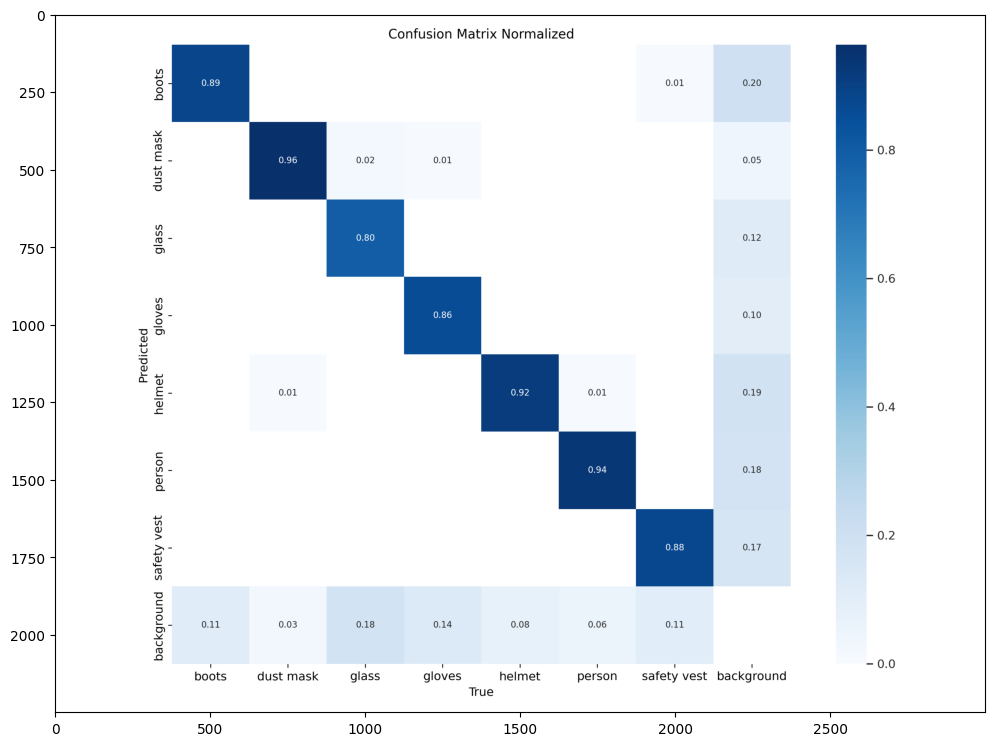

In [18]:
# Evaluate with train set 
fig = plt.figure(figsize= (12,12))
confusion_matrix_path = 'runs/detect/yolov8m.pt_train_120_epochs/confusion_matrix_normalized.png'
confusion_matrix_image = plt.imread(confusion_matrix_path)
plt.imshow(confusion_matrix_image)
plt.show()

In [19]:
# Precise and Recall 
result = pd.read_csv('runs/detect/yolov8m.pt_train_120_epochs/results.csv')
result.tail()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
211,104,0.82164,0.44390,1.0696,0.86899,0.86438,0.89097,0.56273,1.2336,0.59643,1.3623,0.000137,0.000137,0.000137
212,105,0.82395,0.43975,1.0716,0.86194,0.87572,0.89292,0.56271,1.2338,0.59523,1.3566,0.000129,0.000129,0.000129
213,106,0.81227,0.44098,1.0650,0.85683,0.87360,0.89117,0.56095,1.2368,0.60435,1.3600,0.000122,0.000122,0.000122
214,107,0.81276,0.43468,1.0622,0.85979,0.87425,0.89124,0.56004,1.2387,0.60149,1.3641,0.000114,0.000114,0.000114
215,108,0.81155,0.43695,1.0687,0.85382,0.87416,0.88984,0.56104,1.2426,0.60274,1.3691,0.000107,0.000107,0.000107


Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7878MiB)
Model summary (fused): 218 layers, 25843813 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /home/quocthinh/Desktop/JupyterCode/MVFinalProject_05/Annotate_PPE

val: New cache created: /home/quocthinh/Desktop/JupyterCode/MVFinalProject_05/Annotate_PPE-4/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        421       2698      0.885      0.802      0.869      0.543
                 boots        421        450      0.871      0.782      0.851      0.478
             dust mask        421        146      0.904      0.906      0.934      0.601
                 glass        421        118      0.752       0.61      0.731      0.334
                gloves        421        394      0.937      0.786      0.864      0.532
                helmet        421        485      0.901      0.845      0.894      0.579
                person        421        616      0.933      0.876      0.942      0.697
           safety vest        421        489      0.896      0.808      0.867      0.579
Speed: 0.6ms preprocess, 16.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val


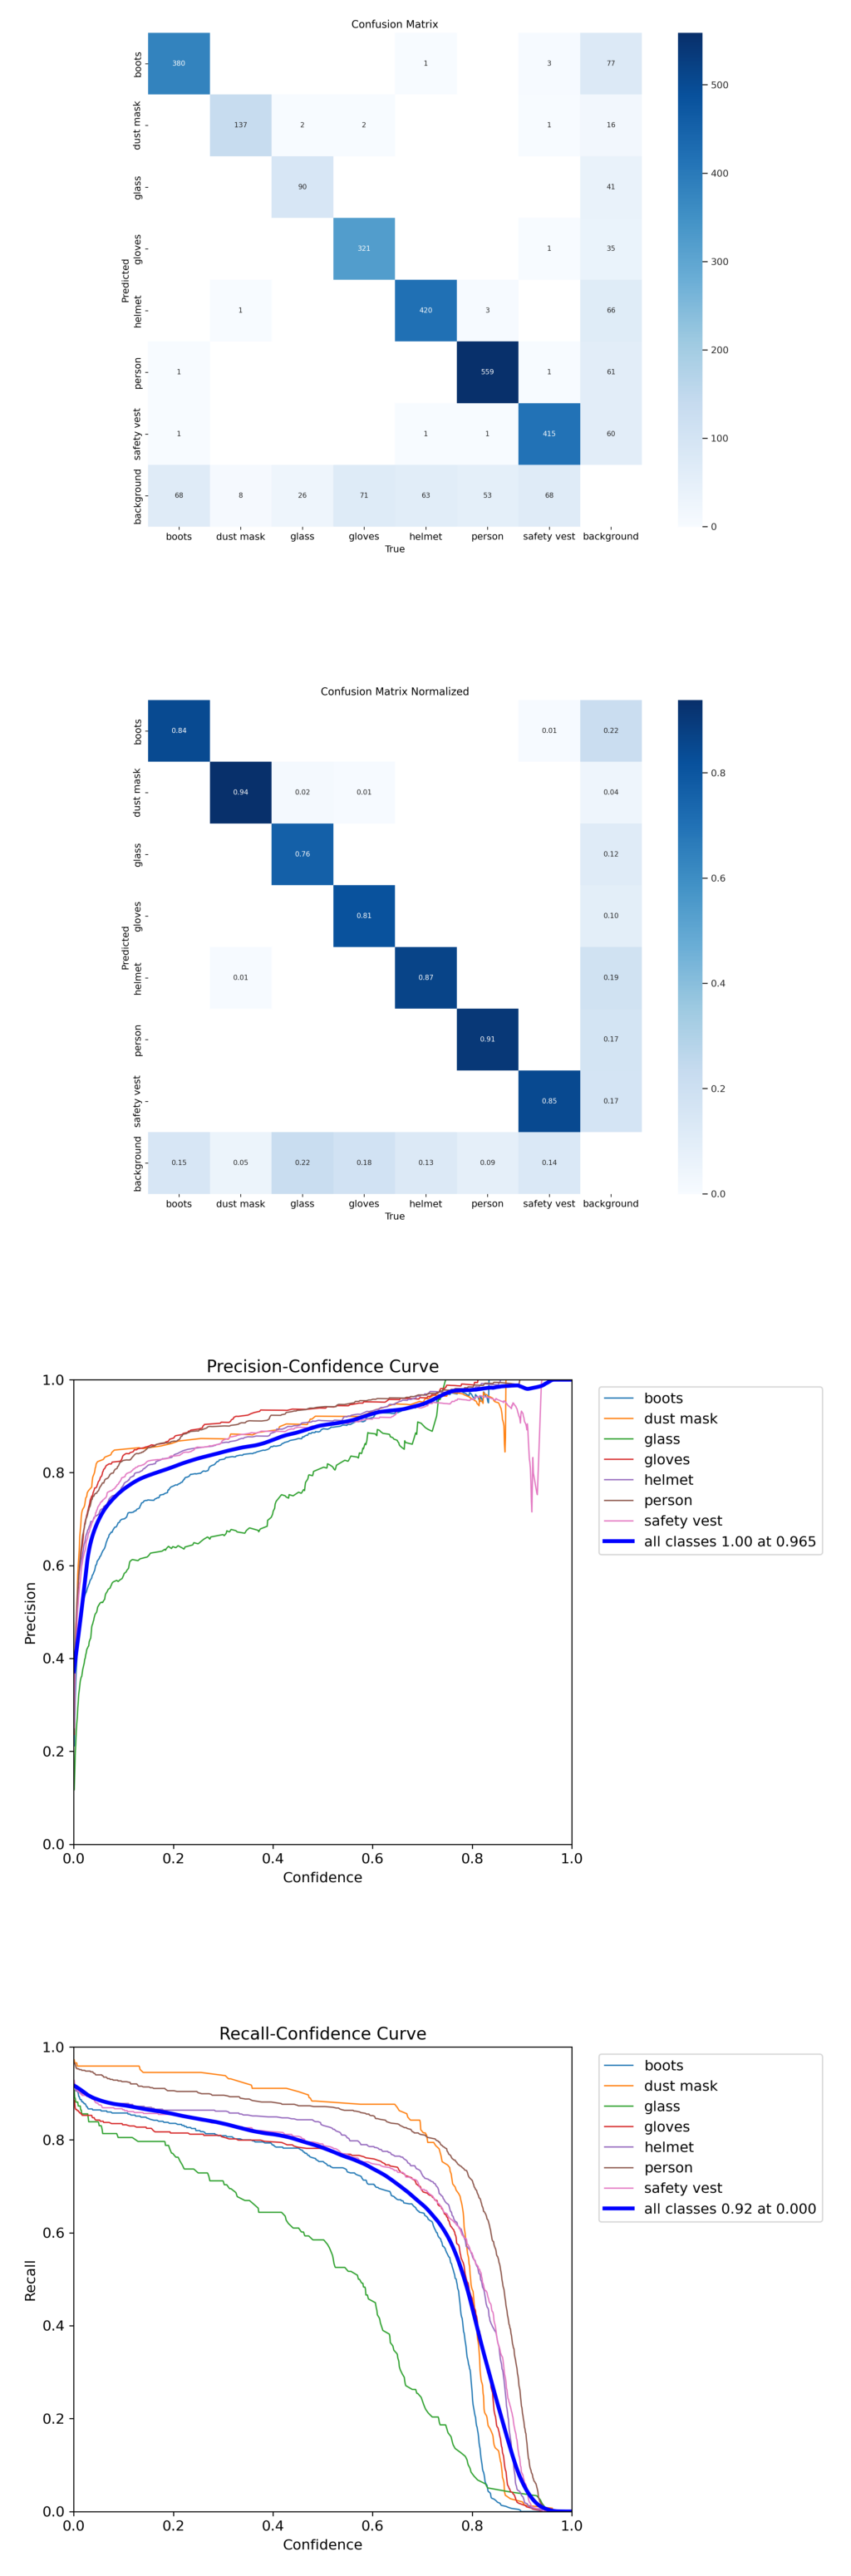

In [7]:
# Evaluate with valid set 
model.evaluate(best_model, 'data.yaml')

#### 2.7 Predict images 


0: 640x640 2 bootss, 2 glovess, 1 helmet, 1 person, 1 safety vest, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


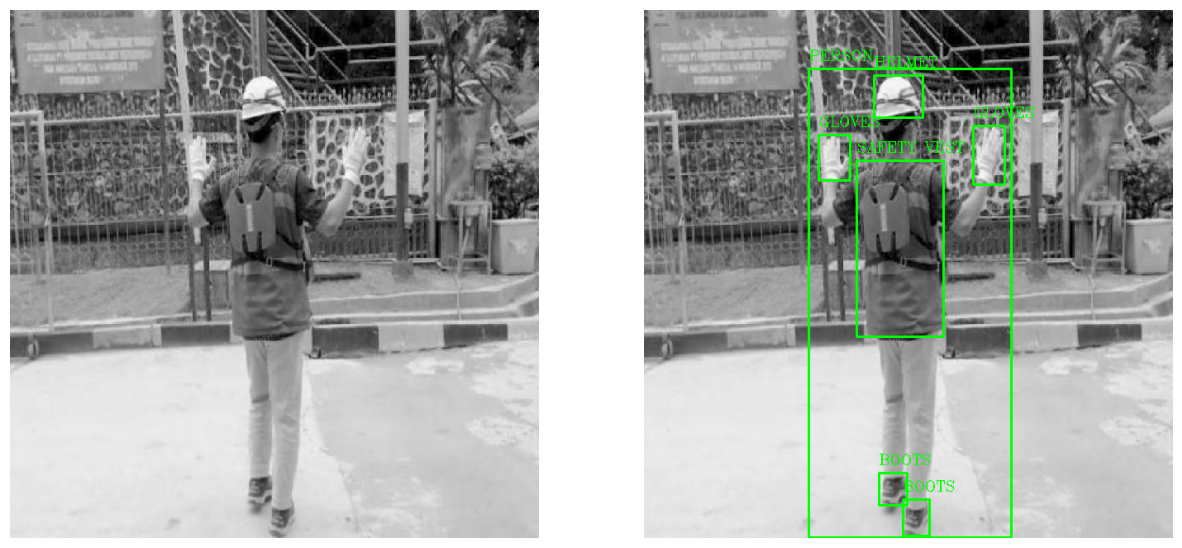

In [9]:
# Predict with image 
images_path = []
images_num = 1 
images = os.listdir(test_folder)
for i in range(images_num): 
    image = np.random.choice(images)
    image_path = os.path.join(test_folder, image)
    images_path.append(image_path)

# Predict image(s)
results = model.predict_images(best_model, images_path)


#### 2.8 Predict video 

In [11]:
# Video path 
video_path = 'DEMO_Detect.mp4'
model.predict_video(best_model, video_path)

Frame width: 1920
Frame height: 1080
FPS: 30

0: 384x640 4 persons, 1 safety vest, 198.8ms
Speed: 7.0ms preprocess, 198.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 safety vest, 9.0ms
Speed: 5.9ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 helmet, 5 persons, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 helmet, 5 persons, 8.9ms
Speed: 7.7ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 8.7ms
Speed: 7.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 helmet, 5 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 helmet, 4 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 38

### 3. Application 

#### 3.1 PPE Inspection

In [12]:
def check_overlap(r1, r2):
    return not (r1[2] < r2[0] or r1[0] > r2[2] or r1[3] < r2[1] or r1[1] > r2[3])

# def check_overlap(box1, box2):
#     """
#     Checks if two bounding boxes overlap.
#     Parameters:
#         - box1, box2 (arrays): Bounding boxes in the format [x1, y1, x2, y2].
#     Returns:
#         - bool: True if boxes overlap, False otherwise.
#     """
#     x1_min, y1_min, x1_max, y1_max = box1
#     x2_min, y2_min, x2_max, y2_max = box2

#     if x1_max < x2_min or x2_max < x1_min or y1_max < y2_min or y2_max < y1_min:
#         return False
#     return True

def create_ppe_status_string(ppe_status):
    status_list = []
    for item, status in ppe_status.items():
        if status:
            status_list.append(f"{item} \033[92m\u2714\033[0m")
        else:
            status_list.append(f"{item} \033[91m\u2718\033[0m")
    return '\n'.join(status_list)
    
def ppe_inspection(results):
    """
    This function inspects PPE for workers.
    Parameters:
        - results (YOLO object): the results of YOLO model prediction for a frame.
    Returns:
        - dict: A dictionary where each key is a tuple of the position of the person and the value is a list of their overlapping classes.
    """
    results = results.cpu().numpy()
    boxes = results.boxes
    positions = boxes.xyxy.astype(int)
    classes = boxes.cls.astype(int)
    scores = boxes.conf

    # Filter detections based on the confidence threshold
    valid_indices = np.where(scores > 0.5)[0]
    positions = positions[valid_indices]
    classes = classes[valid_indices]
    scores = scores[valid_indices]

    # Check if there are any persons
    person_indices = np.where(classes == 5)[0]
    person_boxes = positions[person_indices]

    # Initialize dictionary to store PPE status
    ppe_status = {}
    ppe_classes = [1, 2, 3, 4, 6]  # Indices of PPE classes 

    # Check overlap for each detected person
    for idx, person_box in enumerate(person_boxes):
        classes_overlap = []
        for i, other_box in enumerate(positions):
            if i not in person_indices and check_overlap(person_box, other_box):
                classes_overlap.append(classes[i])

        # Convert person_box to a tuple so it can be used as a dictionary key
        person_box_tuple = tuple(person_box.astype(int))

        # Convert classes_overlap for easily visualizing
        classes_overlap = np.unique(classes_overlap)
        dict_classes = {CLASSES_NAME[cls].title(): (cls in classes_overlap) for cls in ppe_classes}

        # Append person position and overlapping classes to the ppe_status dictionary
        ppe_status[person_box_tuple] = dict_classes

    return ppe_status


In [13]:
video_path = 'DEMO_PPE_Inspection.mp4'
cap = cv.VideoCapture(video_path)

if not cap.isOpened():
    raise ValueError("Error opening video file")

# Get video information
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv.CAP_PROP_FPS))

output_path = 'ppe_inspection_output.avi'

# Print out video information
print('Frame width:', frame_width)
print('Frame height:', frame_height)
print('FPS:', fps)

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Vertical position start
y_offset_start = 800
line_height = 50  # Height of each text line

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print('Can not read the frame')
        break
        
    # Define the region of interest 
    roi = frame[17: 1080, 610 : 1235]

    # Detect with YOLO model 
    detects = best_model(roi)[0]
    detects = detects.cpu().numpy()
    classes = detects.boxes.cls.astype(int)

    output_text = None
    if np.any(classes == 5):  # Check if 'person' class is detected
        ppe_status = ppe_inspection(detects)
        y_offset = y_offset_start
        for person, status in ppe_status.items():
            if person[1] < 50 and person[3] > 1050:  # Detect for only person in the region of interest
                for cls, retval in status.items():
                    color = (0, 255, 0) if retval else (0, 0, 255)
                    cv.putText(frame, f'{cls}'.upper(), (30, y_offset), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    y_offset += line_height
        
    out.write(frame)
    # cv.imshow('Frame', frame)
    # if cv.waitKey(1) & 0xFF == ord('q'):
    #         break
        

cap.release()
out.release()
cv.destroyAllWindows()

Frame width: 1920
Frame height: 1080
FPS: 30

0: 640x384 1 helmet, 1 person, 1 safety vest, 197.8ms
Speed: 5.0ms preprocess, 197.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 8.8ms
Speed: 5.3ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 8.6ms
Speed: 5.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 8.9ms
Speed: 5.4ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 helmet, 1 person, 1 safety vest, 8.6ms
Spee

#### 3.2 Detect worker in construction

In [14]:
def Show_Status_and_Alert (img , person_tracking_ppe, number_worker, number_normal_person, show_worker=True, show_normal_person=True):
    '''
    This function will show the status of PPE for each person, alert when appearing normal person, also count the number of workers
    Parameters:
        - img (np.array): which is a frame or image 
        - person_tracking_ppe (dict): which is a dictionary containing the coordinates of the bouding box for each person with the status of the PPE
    Return: 
        - number_worker (int): this function also return the number of workers appearing in the frame
        - number_normal_person (int): this function also return the number of normal person appearing in the frame
    '''
    
    # Detect Worker based on the PPE status    
    for person, ppe_status in person_tracking_ppe.items():
        
        # Print the status of PPE for each person
        # Check the normal personMode3_test_1.mov
        if (ppe_status['Safety Vest'] == False) and (ppe_status['Helmet'] == False) :
            # Track the normal person
            normal_person = img[person[1]:person[3], person[0]:person[2]]
            number_normal_person += 1
            if show_normal_person:
                cv.rectangle(img, (person[0], person[1]), (person[2], person[3]), (0,0,255), 2)
                cv.putText(img, "ALERT !!!", (person[0]+10, person[1]+100), 
                        cv.FONT_HERSHEY_COMPLEX, 0.7, (0,0,255), 2)
        else: 
            # Track the worker with PPE
            worker = img[person[1]:person[3], person[0]:person[2]]
            number_worker += 1
            if show_worker:
                cv.rectangle(img, (person[0], person[1]), (person[2], person[3]), (0,255,0), 2)
                cv.putText(img, "Worker", (person[0]-20, person[1]-10), 
                        cv.FONT_HERSHEY_COMPLEX, 0.4, (0,255,0), 2)
            
    return number_worker, number_normal_person

In [15]:
def Worker_Detection(input_path, output_path):
    
    # Load the video
    cap = cv.VideoCapture(input_path)
    frame_size = tuple(reversed(cap.read()[1].shape[:2]))
    
    if not cap.isOpened():
        print("Error: Couldn't open video")
        return
    
    fps = cap.get(cv.CAP_PROP_FPS)
    
    # Define the codec and create the video
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    output = cv.VideoWriter(output_path, fourcc, fps=fps, frameSize=frame_size)
    
    # Monitoring FPS 
    frame_count = 0
    start_time = time.time()
    
    # Apply the model for each frame
    while True: 
        
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Initialize 
        number_worker = 0
        number_normal_person = 0
        
        # Detect with YOLO model 
        detects = best_model(frame)[0]
        
        # Check PPE 
        person_tracking_ppe = ppe_inspection(detects)
        
        # Show the status and alert when appearing normal person
        number_worker, number_normal_person = Show_Status_and_Alert(frame, person_tracking_ppe, number_worker, number_normal_person)
        
        # Show the number of workers and number of normal persons
        cv.putText(frame, "Number of workers: " + str(number_worker), (30, 30), cv.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2)
        cv.putText(frame, "Number of normal persons: " + str(number_normal_person), (30, 60), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
        
        # Write the frame into the output video
        output.write(frame)
        
        # After executing this script, frame will be updated
        frame_count += 1
        
        # Calculate FPS
        # if frame_count % int(fps) == 0:
        end_time = time.time()
        duration = end_time - start_time
        current_fps = frame_count/duration
        print("Curren FPS: ", current_fps)
        frame_count = 0
        start_time = time.time()
            
        key = cv.waitKey(20)
        if key == 27:
            break
        
    cap.release()
    output.release()
    cv.destroyAllWindows()

In [16]:
video_path = 'DEMO_Detect.mp4'
Worker_Detection(video_path, 'output_detect_mode.avi')


0: 384x640 4 persons, 1 safety vest, 9.5ms
Speed: 13.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  15.933686629817464

0: 384x640 1 helmet, 5 persons, 8.6ms
Speed: 7.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  11.61297324835121

0: 384x640 1 helmet, 5 persons, 9.1ms
Speed: 6.1ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  14.921516519561282

0: 384x640 5 persons, 8.6ms
Speed: 6.1ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  12.741479715053845

0: 384x640 1 helmet, 5 persons, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  14.093147812763556

0: 384x640 1 helmet, 4 persons, 8.7ms
Speed: 8.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  13.439405299753277

0:

#### 3.3 Tracking worker in construction 

In [17]:
def result_table(number_worker, require_number):
    
    current_datetime = datetime.datetime.now()

    formated_datetime = current_datetime.strftime("%B %d, %Y %H:%M:%S")
        
    data = {
        "Date time"        : [],
        "Number of workers": [],
        "State"            : []
    }
    
    if number_worker == require_number:
        
        data["Date time"].append(formated_datetime)
        data["Number of workers"].append(number_worker)
        data["State"].append("Normal")
        
    elif number_worker < require_number:
        
        data["Date time"].append(formated_datetime)
        data["Number of workers"].append(number_worker)
        data["State"].append("Missing")

    else: 
        data["Date time"].append(formated_datetime)
        data["Number of workers"].append(number_worker)
        data["State"].append("Redundant")
    
    return data

In [25]:
def Tracking_Construction_Worker(input_path, output_path):
    
    # Load the video
    cap = cv.VideoCapture(input_path)
    frame_size = tuple(reversed(cap.read()[1].shape[:2]))
    
    if not cap.isOpened():
        print("Error: Couldn't open video")
        return
    
    fps = cap.get(cv.CAP_PROP_FPS)
    
    # Define the codec and create the video
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    output = cv.VideoWriter(output_path, fourcc, fps=fps, frameSize=frame_size)
    
    # Monitoring FPS 
    frame_count = 0
    start_time = time.time()
    
    delay_time = 0 # For delaying the detection of the model
    dataframe = pd.DataFrame() # A dataframe to monitor the number of workers appearance
    number_detection = 0
    
    # Apply the model for each frame
    while True: 
        
        ret, frame = cap.read()
        if not ret:
            break
        
        person_tracking_ppe = {}
        number_normal_person = 0
        delay_time += 1
        number_worker = 0

       # Detect with YOLO model 
        detects = best_model(frame)[0]
        
        # Check PPE 
        person_tracking_ppe = ppe_inspection(detects)
        
        # Show the status and alert when appearing normal person
        number_worker, number_normal_person = Show_Status_and_Alert(frame, person_tracking_ppe, number_worker, number_normal_person)
        if delay_time > 33:
            number_detection += 1
    
            # Take the information to the dataframe and save it to csv file, The require number of workers in the area is 5
            data = result_table(number_worker, require_number=5)
            df1 = pd.DataFrame(data)
            dataframe = pd.concat([dataframe, df1])
            dataframe.to_csv('Tracking_State.csv', index=False)
    
            delay_time = 0
    
        cv.putText(frame, "Number of workers: " + str(number_worker), (30, 30),
                   cv.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 2)
        cv.putText(frame, "Number of detection " + str(number_detection), (30, 60),
                   cv.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 255), 2)

        
        # Write the frame following the output_path
        output.write(frame)
        
        # After executing this script, frame will be updated
        frame_count += 1
        
        # Calculate FPS
        # if frame_count % int(fps) == 0:
        end_time = time.time()
        duration = end_time - start_time
        current_fps = frame_count/duration
        print("Curren FPS: ", current_fps)
        frame_count = 0
        start_time = time.time()
        
        # Set key to turn off the display
        key = cv.waitKey(30)
        if key == 27:
            break
        
    cap.release()
    output.release()
    cv.destroyAllWindows()

In [26]:
Tracking_Construction_Worker('DEMO_Tracking_15s.mp4', 'tracking_output_mode.avi')


0: 384x640 3 helmets, 5 persons, 4 safety vests, 9.6ms
Speed: 12.7ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  16.073517407882886

0: 384x640 3 helmets, 5 persons, 4 safety vests, 8.8ms
Speed: 6.0ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  12.649104765236482

0: 384x640 3 helmets, 5 persons, 5 safety vests, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  12.604705535871522

0: 384x640 3 helmets, 5 persons, 5 safety vests, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  13.362677694165324

0: 384x640 3 helmets, 5 persons, 5 safety vests, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Curren FPS:  12.519824603821345

0: 384x640 3 helmets, 5 persons, 5 safety vests, 8.6ms
Speed: 6.9ms preproce